In [1]:
import os
import torch
import matplotlib.pyplot as plt
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [2]:
import json


In [3]:
torch.cuda.is_available()

True

In [4]:
PROJECT_ROOT = os.getcwd()

In [5]:
test_path =PROJECT_ROOT +'/test/'


In [6]:
import numpy as np
import random

In [7]:
def set_seed(seed=42):
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False
set_seed(42)

In [8]:
from glob import glob

def load_data(test_path):
    image_list = []
    label_list = []

    label_map = {
        'no_tumor': 0,
        'tumor': 1
    }
    
    # loop through each label folder
    for label_name, label_value in label_map.items():
        folder_path = os.path.join(test_path, label_name)

        # get images in the folder
        image_paths = glob(os.path.join(folder_path, '*'))
        print()
        for image_path in image_paths:
            image_list.append(image_path)
            label_list.append(label_value)
    return image_list, label_list

In [9]:
X_test_paths, y_test = load_data(test_path)
no_tumor_idx = [i for i, label in enumerate(y_test) if label == 0][10]
no_tumor_image_path = X_test_paths[no_tumor_idx]

tumor_idx = [i for i, label in enumerate(y_test) if label == 1][100]
tumor_image_path = X_test_paths[tumor_idx]


In [10]:
# SVM
# extract HOG features
import numpy as np
from skimage.io import imread 
from skimage.transform import resize
from skimage.feature import hog
from sklearn.svm import SVC
def extract_hog_features(test_path, img_size=(128,128)):
    features = []
    feature_length_printed = False
    for path in test_path:
        try:
            image = imread(path, as_gray=True)
            image = resize(image, img_size)
            hog_feature = hog(image, pixels_per_cell=(16,16), cells_per_block=(2,2), feature_vector=True)
            if not feature_length_printed:
                feature_length_printed = True
            
            features.append(hog_feature)   
               
        except Exception as e:
            print(f"Fail to process {path}: {e}")
    
    return np.array(features)


In [11]:
X_test_paths, y_test = load_data(test_path)
X_test_hog = extract_hog_features(X_test_paths)

In [12]:
# load saved SVM model and prediction
import joblib
model_dir_SVM = os.path.join(PROJECT_ROOT, 'SVM_HOG')
model_filename_SVM = 'best_svm_hog_model.pkl'
model_path_SVM= os.path.join(model_dir_SVM, model_filename_SVM)
svm_model = joblib.load(model_path_SVM)

In [13]:
import matplotlib.pyplot as plt
from skimage.feature import hog
from skimage.io import imread
from skimage.transform import resize
import numpy as np

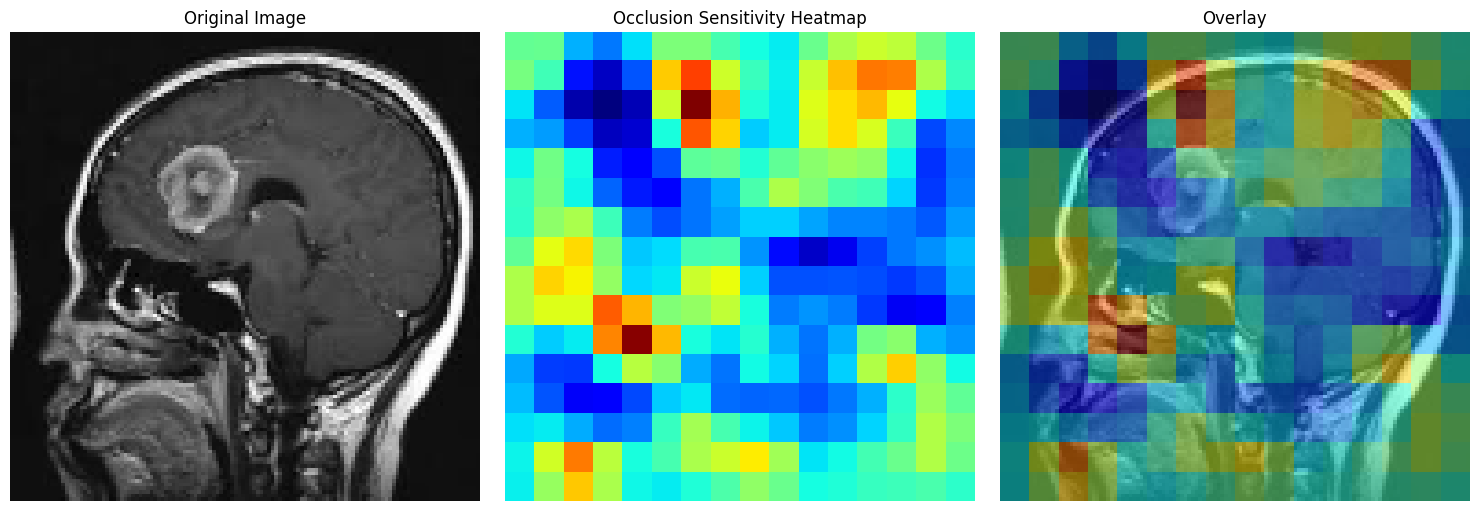

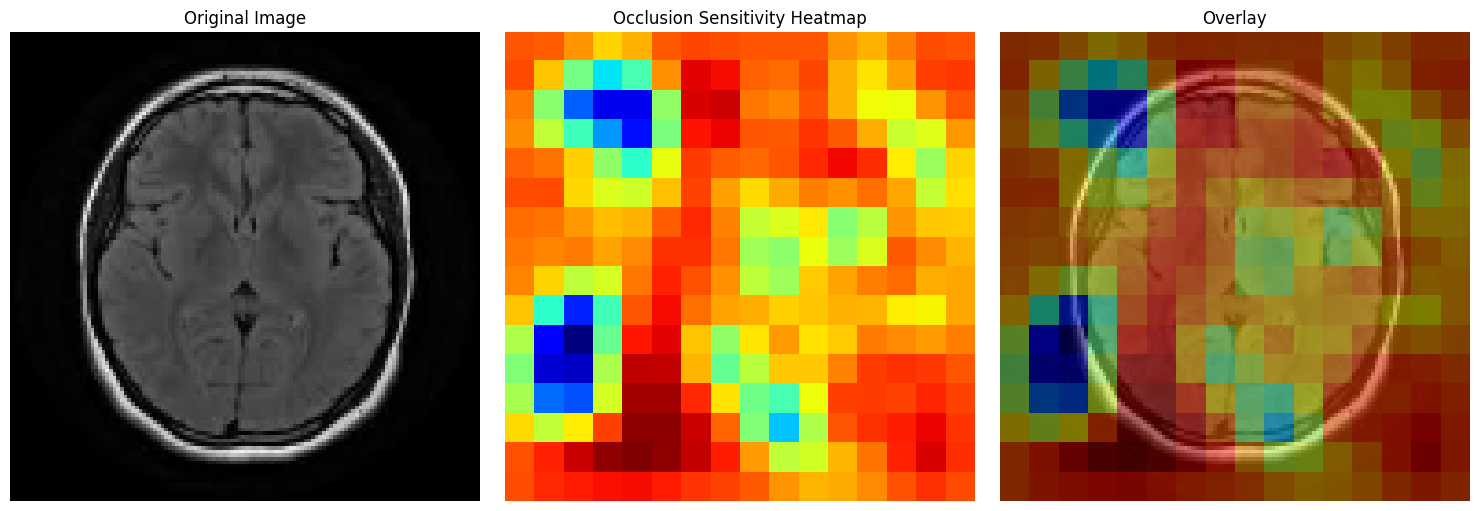

In [14]:
import numpy as np
import matplotlib.pyplot as plt
from skimage.io import imread
from skimage.transform import resize
from skimage.feature import hog

def occlusion_sensitivity(
        image_path,
        clf,
        patch_size=32, #32X32 pixels is masked region to test importance - how important is this specific region to the models' prediction.
        stride=16,     # the patch moves 16 pixels at a time horizontally and vertically. overlap between patches ensures no regions are skipped
        img_size=(128,128),
        pixels_per_cell=(16,16),
        cells_per_block=(2,2)
        ):
    # Load and preprocess the image
    original_image = imread(image_path, as_gray=True)
    original_image = resize(original_image, img_size, anti_aliasing=True)

    # Compute base probability
    hog_feature = hog(original_image, pixels_per_cell=pixels_per_cell, cells_per_block=cells_per_block, feature_vector=True)
    base_prob = clf.predict_proba([hog_feature])[0][1] # probability of "tumor" based on the unoccluded image as baseline purposing.
                                                       # shape(n_samples, n_classes)

    # Initialize heatmap
    heatmap = np.zeros(img_size)

    # Slide occlusion patch; the reason why need overlap to ensure all regions are tested multiple times in slightly diff contexts. and produce a smoother, less noisy heatmap. 
    for y in range(0, img_size[0] - patch_size + 1, stride): 
        for x in range(0, img_size[1] - patch_size + 1, stride):
            occluded_image = original_image.copy()
            occluded_image[y:y+patch_size, x:x+patch_size] = 0.5 # gray occlusion
            hog_feature_occ = hog(occluded_image, pixels_per_cell=pixels_per_cell, cells_per_block=cells_per_block, feature_vector=True)
            occ_prob = clf.predict_proba([hog_feature_occ])[0][1] # probability of 'tumor' based on a specific patch is occluded. 

            # Compute drop to test how much the occluding a region reduces the model's confidence. if it's large positive, meaning region was important for tumor prediction. 
            drop = base_prob - occ_prob
            #print(f"Patch at ({y}, {x}) drop: {drop:.4f}")
            heatmap[y:y+patch_size, x:x+patch_size] += drop
        # Normalize heatmap
    heatmap -= heatmap.min()
    heatmap /= heatmap.max()

    return original_image, heatmap


# test 1 image
# tumor image 
image_path = tumor_image_path
#image_path = "/home/yuting/NLP project/01-NLP-Python-Basics/brain tumor image project/validation/tumor/m3 (20).jpg"
original_image, heatmap = occlusion_sensitivity(
    image_path,
    clf=svm_model, # your trained SVM model
    patch_size=16,
    stride=8,
    img_size=(128,128)
    )

# Plot results
plt.figure(figsize=(15,5))

plt.subplot(1,3,1)
plt.title("Original Image")
plt.imshow(original_image, cmap='gray')
plt.axis('off')

plt.subplot(1,3,2)
plt.title("Occlusion Sensitivity Heatmap")
plt.imshow(heatmap, cmap='jet')
plt.axis('off')

plt.subplot(1,3,3)
plt.title("Overlay")
plt.imshow(original_image, cmap='gray')
plt.imshow(heatmap, cmap='jet', alpha=0.5)
plt.axis('off')

plt.tight_layout()
plt.show()

# no tumor image 
image_path = no_tumor_image_path

original_image, heatmap = occlusion_sensitivity(
    image_path,
    clf=svm_model, # your trained SVM model
    patch_size=16,
    stride=8,
    img_size=(128,128)
    )

# Plot results
plt.figure(figsize=(15,5))

plt.subplot(1,3,1)
plt.title("Original Image")
plt.imshow(original_image, cmap='gray')
plt.axis('off')

plt.subplot(1,3,2)
plt.title("Occlusion Sensitivity Heatmap")
plt.imshow(heatmap, cmap='jet')
plt.axis('off')

plt.subplot(1,3,3)
plt.title("Overlay")
plt.imshow(original_image, cmap='gray')
plt.imshow(heatmap, cmap='jet', alpha=0.5)
plt.axis('off')

plt.tight_layout()
plt.show()

In [15]:
def visualize_hog_on_image(
image_path,
img_size=(128, 128),
pixels_per_cell=(16, 16),
cells_per_block=(2, 2),
orientations=9
):
    # Load and resize image
    image = imread(image_path, as_gray=True)
    image_resized = resize(image, img_size, anti_aliasing=True)

    # Generate HOG features and visualization image, hog() is the HOG extractor and computes HOG features from an input image. 
    # the features is a flatterned 1D array and it can be used as an SVM input. 
    features, hog_image = hog(
        image_resized,
        orientations=orientations,
        pixels_per_cell=pixels_per_cell,
        cells_per_block=cells_per_block,
        visualize=True,
        feature_vector=True
        )

    # Normalize HOG image for overlay
    hog_image_norm = (hog_image - hog_image.min()) / (hog_image.max() - hog_image.min())

    # Overlay preparation, combine 70% HOG visualization and 30% original image. 
    overlay = np.stack([hog_image_norm]*3, axis=-1) * 0.7 + np.stack([image_resized]*3, axis=-1) * 0.3
    overlay = np.clip(overlay, 0, 1)

    # Plot
    fig, axs = plt.subplots(1, 3, figsize=(15, 5))

    axs[0].imshow(image_resized, cmap='gray')
    axs[0].set_title('Original Image')
    axs[0].axis('off')

    axs[1].imshow(hog_image, cmap='jet')
    axs[1].set_title('HOG Feature Visualization')
    axs[1].axis('off')

    axs[2].imshow(overlay)
    axs[2].set_title('Overlay: Image + HOG Features')
    axs[2].axis('off')

    plt.tight_layout()
    plt.show()

    return fig

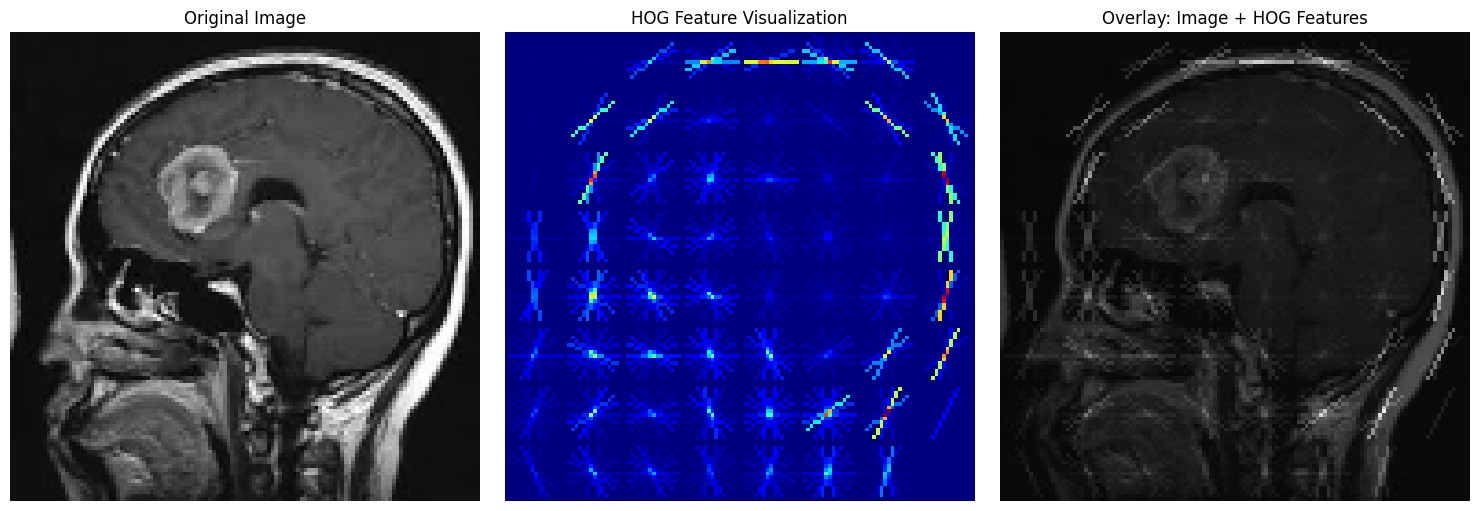

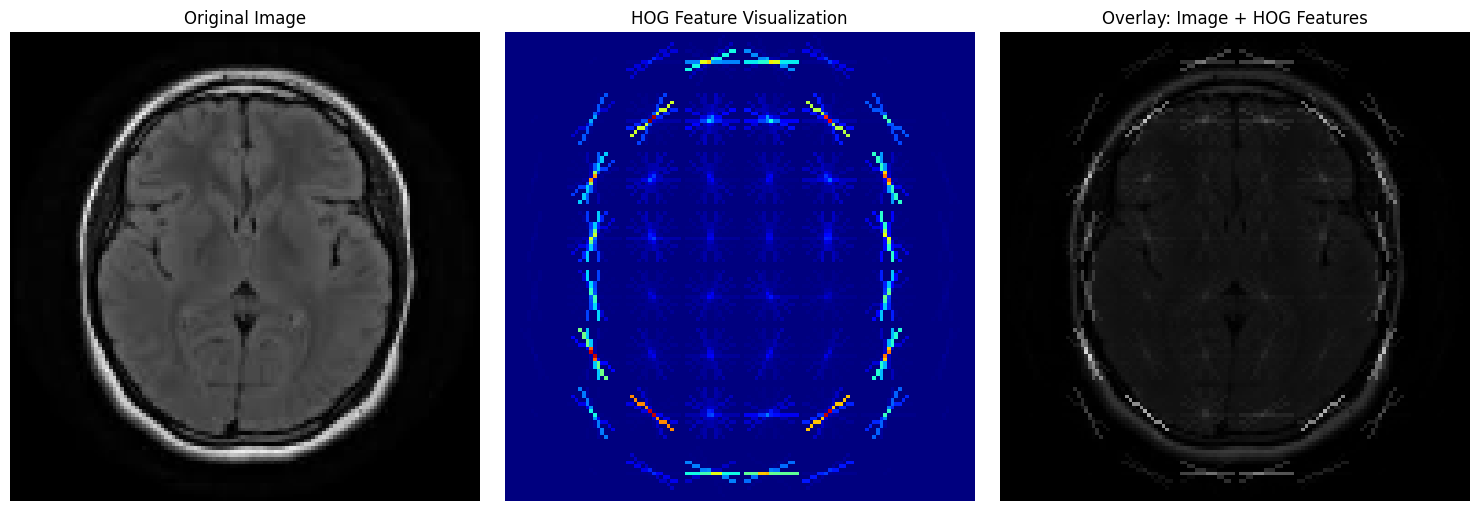

In [16]:

# tumor
image_path = tumor_image_path
fig = visualize_hog_on_image(image_path)

# no tumor
image_path = no_tumor_image_path
fig = visualize_hog_on_image(image_path)


In [17]:
from sklearn.metrics import classification_report
y_pred_svm = svm_model.predict(X_test_hog)
print(classification_report(y_test, y_pred_svm))

              precision    recall  f1-score   support

           0       0.89      0.90      0.89        60
           1       0.98      0.98      0.98       372

    accuracy                           0.97       432
   macro avg       0.93      0.94      0.94       432
weighted avg       0.97      0.97      0.97       432



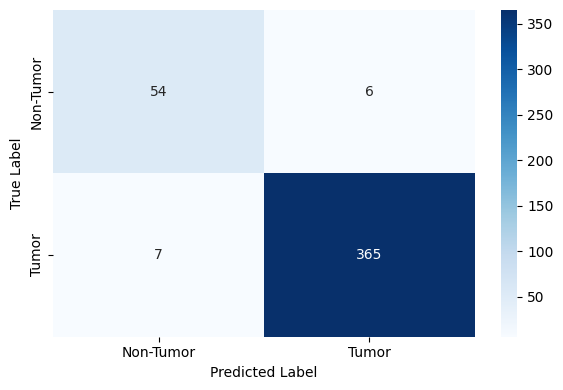

In [18]:
# confusion matrix
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
cm = confusion_matrix(y_test, y_pred_svm)
plt.figure(figsize=(6,4))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=['Non-Tumor', 'Tumor'],
            yticklabels=['Non-Tumor','Tumor'])
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('')
plt.tight_layout()
plt.show()

In [19]:
# resnet18 applied in unseen data 
import json
from torch.utils.data import Dataset, DataLoader
from PIL import Image
import torchvision.models as models
import torchvision.transforms as transforms
from torch import nn, optim
from torchvision.datasets import ImageFolder
from torchvision import datasets, transforms, models # add models to the list
from sklearn.metrics import classification_report

In [20]:
def set_seed(seed=42):
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False
set_seed(42)

In [21]:
from glob import glob
# load annotation and get image path and labels
class TumorDataset(Dataset):
    def __init__(self, data_path, transform=None):
        
        self.samples = []
        self.label_map = {
            'no_tumor': 0,
            'tumor': 1
            }
        for label_name, label_value in self.label_map.items():
            folder_path = os.path.join(data_path, label_name)
            image_paths = glob(os.path.join(folder_path, '*'))

            for image_path in image_paths:
                self.samples.append((
                    image_path, label_value
                    ))   
            self.transform = transform

    def __len__(self):
        return len(self.samples)

    def __getitem__(self, idx):
        image_path, label = self.samples[idx] # [(image_path_0, label_0), (image_path_1, label_1)...]
        image = Image.open(image_path).convert('RGB') # (H, W, 3)
        if self.transform:
            image = self.transform(image) # after calling transform(), convert from PIL image with the shape(H,W,3) and value [0,225] to shape(3, H, W) and value [0.0, 1.0]
        return image, label

In [22]:
# without augmentation: just re-size and normalize
test_tranform_no_aug = transforms.Compose([
        transforms.Resize(224),
        transforms.CenterCrop(224),
        transforms.ToTensor(),
        transforms.Normalize([0.5],[0.5])
    ])



In [23]:
test_no_aug = TumorDataset(
    data_path = test_path,
    transform=test_tranform_no_aug
)

test_loader_no_aug = DataLoader(test_no_aug, batch_size = 32)


In [24]:
# load the saved best saved model
device = torch.device('cuda' if torch.cuda.is_available() else "cpu")

In [25]:
# from here, resnet18 model evaluate on test data
import torch
import torch.nn as n
from torchvision import models
from torchvision.models import resnet18, ResNet18_Weights

In [26]:
resnet18_model = models.resnet18(weights=ResNet18_Weights.DEFAULT)
    # freeze all layers
for param in resnet18_model.parameters():
    param.requires_grad = False
    
    # unfreeze three block and fc
for param in resnet18_model.layer2.parameters():
    param.requires_grad = True
for param in resnet18_model.layer3.parameters():
    param.requires_grad = True
for param in resnet18_model.layer4.parameters():
    param.requires_grad = True
resnet18_model.fc = nn.Sequential(
    nn.Dropout(0.4),
    nn.Linear(resnet18_model.fc.in_features, 2)
    )

model_dir_resnet18 = os.path.join(PROJECT_ROOT, 'ResNet18')
model_filename_resnet18= 'best_resnet18_overall.pth'
model_path_resnet18 = os.path.join(model_dir_resnet18, model_filename_resnet18)
resnet18_model.load_state_dict(torch.load(model_path_resnet18))
resnet18_model = resnet18_model.to(device)
resnet18_model.eval()

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

In [27]:
def evaluate_with_outputs(resnet18_model, loader):
    resnet18_model.eval()
    all_preds = []
    all_labels = []
    with torch.no_grad():
        for X_batch, y_batch in loader:
            X_batch, y_batch = X_batch.to(device), y_batch.to(device)
            outputs = resnet18_model(X_batch)
            preds = outputs.argmax(dim=1)
            all_preds.extend(preds.cpu().numpy())
            all_labels.extend(y_batch.cpu().numpy())
    return all_preds, all_labels


In [28]:
def generate_saliency_map(model, image_tensor, label, device):
    image_tensor = image_tensor.unsqueeze(0).to(device) # shape:(3, H, W) --> (1,3,H,W)
    image_tensor.requires_grad_() # compute gradient with respect to the input image

    output = model(image_tensor)  
    output[0, label].backward() # compute gradients of the output(specific class logit) with respect to the input image
                                # backpropagates from the score for the true class. 
    saliency = image_tensor.grad.data.abs().squeeze().cpu() 
    # this measure the rate of change of output score with respect to a tiny change in that pixel.
  


    saliency, _ = torch.max(saliency, dim=0) 
    # reduce channels (R,G,B) to a 2D saliency map with the max gradient across channels at each pixel.
    # before max(), the shape is (3,224,224), after max(), the shape is (224,224)

    return saliency 

label value:  1
True label:  Tumor


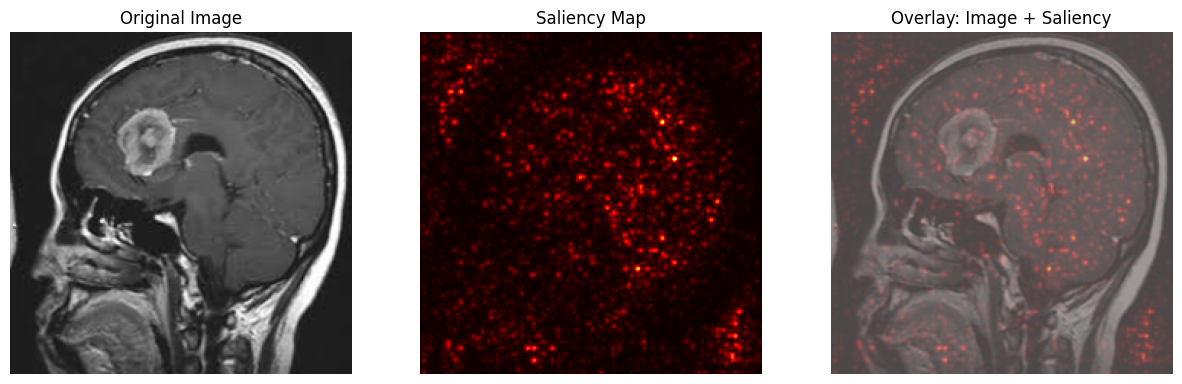

label value:  0
True label:  No Tumor


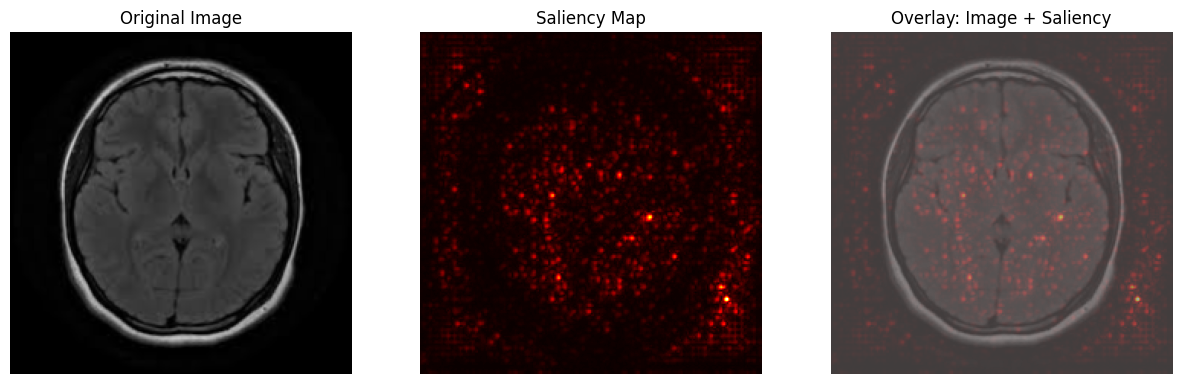

In [29]:
import matplotlib.pyplot as plt
import numpy as np

#sample_img, sample_label = test_no_aug[100] 
sample_img, sample_label = test_no_aug[tumor_idx] 
# after calling test_no_aug, the sample_img tensor shape is (3, 224, 224), its correpsonding output value e.g tensor([0.76, 0.72. 0.87])

saliency_map = generate_saliency_map(resnet18_model, sample_img, sample_label, device)
print("label value: ", sample_label)
print("True label: ", "Tumor" if sample_label == 1 else "No Tumor")

# Denormalize for display
mean = np.array([0.5, 0.5, 0.5])
std = np.array([0.5, 0.5, 0.5])
sample_img_disp = sample_img.permute(1,2,0).cpu().numpy() 
sample_img_disp = std * sample_img_disp + mean
sample_img_disp = np.clip(sample_img_disp, 0, 1)

plt.figure(figsize=(15,5))

# Original Image
plt.subplot(1, 3, 1)
plt.imshow(sample_img_disp) #sample_img (H,W,3)
plt.title('Original Image')
plt.axis('off')

# Saliency Map
plt.subplot(1, 3, 2)
plt.imshow(saliency_map, cmap='hot') 
# saliency_map shows the saliency value- bright red~ high sensitivity (pixel changes influence prediction strongly)
# cmap = 'hot': is a colormap that maps scalar values to RGB colors for visualization. 

plt.title('Saliency Map')
plt.axis('off')

# Overlay
plt.subplot(1, 3, 3)
plt.imshow(sample_img_disp, alpha=0.6)
plt.imshow(saliency_map, cmap='hot', alpha=0.4)
plt.title('Overlay: Image + Saliency')
plt.axis('off')

plt.show()

sample_img, sample_label = test_no_aug[no_tumor_idx] 
# after calling test_no_aug, the sample_img tensor shape is (3, 224, 224), its correpsonding output value e.g tensor([0.76, 0.72. 0.87])


saliency_map = generate_saliency_map(resnet18_model, sample_img, sample_label, device)
print("label value: ", sample_label)
print("True label: ", "Tumor" if sample_label == 1 else "No Tumor")

# Denormalize for display
mean = np.array([0.5, 0.5, 0.5])
std = np.array([0.5, 0.5, 0.5])
sample_img_disp = sample_img.permute(1,2,0).cpu().numpy() 
sample_img_disp = std * sample_img_disp + mean
sample_img_disp = np.clip(sample_img_disp, 0, 1)

plt.figure(figsize=(15,5))

# Original Image
plt.subplot(1, 3, 1)
plt.imshow(sample_img_disp) #sample_img (H,W,3)
plt.title('Original Image')
plt.axis('off')

# Saliency Map
plt.subplot(1, 3, 2)
plt.imshow(saliency_map, cmap='hot') 
# saliency_map shows the saliency value- bright red~ high sensitivity (pixel changes influence prediction strongly)
# cmap = 'hot': is a colormap that maps scalar values to RGB colors for visualization. 

plt.title('Saliency Map')
plt.axis('off')

# Overlay
plt.subplot(1, 3, 3)
plt.imshow(sample_img_disp, alpha=0.6)
plt.imshow(saliency_map, cmap='hot', alpha=0.4)
plt.title('Overlay: Image + Saliency')
plt.axis('off')

plt.show()

In [30]:

preds_no_aug, labels_no_aug = evaluate_with_outputs(resnet18_model, test_loader_no_aug)


In [31]:
# classification reports
print("classification report without argumentation:")
print(classification_report(labels_no_aug, preds_no_aug, target_names=['Non-Tumor', 'Tumor']))



classification report without argumentation:
              precision    recall  f1-score   support

   Non-Tumor       0.97      0.98      0.98        60
       Tumor       1.00      0.99      1.00       372

    accuracy                           0.99       432
   macro avg       0.98      0.99      0.99       432
weighted avg       0.99      0.99      0.99       432



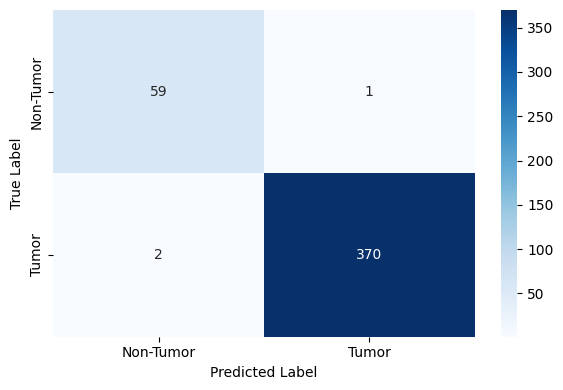

In [32]:
# confusion matrix
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

#without augmentation
cm_no_aug = confusion_matrix(labels_no_aug, preds_no_aug)
plt.figure(figsize=(6,4))
sns.heatmap(cm_no_aug, annot=True, fmt='d', cmap='Blues',
            xticklabels=['Non-Tumor', 'Tumor'],
            yticklabels=['Non-Tumor','Tumor'])
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('')
plt.tight_layout()
plt.show()




In [33]:
# vit-B/16 on unseen data
import torch
from torchvision import models
from torchvision.models import vit_b_16, ViT_B_16_Weights
#import timm
from torch.utils.data import Dataset, DataLoader
from PIL import Image
import torchvision.models as models
import torchvision.transforms as transforms
from torch import nn, optim
from torchvision.datasets import ImageFolder
from torchvision import datasets, transforms, models # add models to the list
from sklearn.metrics import classification_report
import torch.nn.functional as F

In [34]:
def set_seed(seed=42):
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False
set_seed(42)

In [35]:
# load the saved best saved model
device = torch.device('cuda' if torch.cuda.is_available() else "cpu")

In [36]:
from glob import glob
# load annotation and get image path and labels
class TumorDataset(Dataset):
    def __init__(self, data_path, transform=None):
        
        self.samples = []
        self.label_map = {
            'no_tumor': 0,
            'tumor': 1
            }
        for label_name, label_value in self.label_map.items():
            folder_path = os.path.join(data_path, label_name)
            image_paths = glob(os.path.join(folder_path, '*'))

            for image_path in image_paths:
                self.samples.append((
                    image_path, label_value
                    ))   
            self.transform = transform

    def __len__(self):
        return len(self.samples)

    def __getitem__(self, idx):
        image_path, label = self.samples[idx]
        image = Image.open(image_path).convert('RGB')
        if self.transform:
            image = self.transform(image)
        return image, label

In [37]:
# without augmentation: just re-size and normalize
test_tranform_no_aug = transforms.Compose([
        transforms.Resize(224),
        transforms.CenterCrop(224),
        transforms.ToTensor(),
        transforms.Normalize([0.5],[0.5])
    ])



In [38]:
test_no_aug = TumorDataset(
    data_path = test_path,
    transform=test_tranform_no_aug
)

test_loader_no_aug = DataLoader(test_no_aug, batch_size = 32) # 32


In [39]:

vit_model= models.vit_b_16(weights=ViT_B_16_Weights.DEFAULT)
    # freeze all layers
for param in vit_model.parameters():
    param.requires_grad = False
    
    # unfreeze last 2 transformer blocks and the classification head
for name, param in vit_model.named_parameters():
     if "encoder.layers.7" in name or "encoder.layers.8" in name or "encoder.layers.9" in name or "encoder.layers.10" in name or "encoder.layers.11" in name or "heads" in name:
         param.requires_grad = True
    

vit_model.heads = nn.Sequential(
    nn.Dropout(0.4),
    nn.Linear(vit_model.heads.head.in_features, 2)
    )

model_dir_vit = os.path.join(PROJECT_ROOT, 'Vit_B_16')
model_filename_vit = 'best_vit_overall.pth'
model_path_vit = os.path.join(model_dir_vit, model_filename_vit)
vit_model = vit_model.to(device)
vit_model.load_state_dict(torch.load(model_path_vit, map_location=device))
vit_model = vit_model #vit_model.to(device)
vit_model.eval()

VisionTransformer(
  (conv_proj): Conv2d(3, 768, kernel_size=(16, 16), stride=(16, 16))
  (encoder): Encoder(
    (dropout): Dropout(p=0.0, inplace=False)
    (layers): Sequential(
      (encoder_layer_0): EncoderBlock(
        (ln_1): LayerNorm((768,), eps=1e-06, elementwise_affine=True)
        (self_attention): MultiheadAttention(
          (out_proj): NonDynamicallyQuantizableLinear(in_features=768, out_features=768, bias=True)
        )
        (dropout): Dropout(p=0.0, inplace=False)
        (ln_2): LayerNorm((768,), eps=1e-06, elementwise_affine=True)
        (mlp): MLPBlock(
          (0): Linear(in_features=768, out_features=3072, bias=True)
          (1): GELU(approximate='none')
          (2): Dropout(p=0.0, inplace=False)
          (3): Linear(in_features=3072, out_features=768, bias=True)
          (4): Dropout(p=0.0, inplace=False)
        )
      )
      (encoder_layer_1): EncoderBlock(
        (ln_1): LayerNorm((768,), eps=1e-06, elementwise_affine=True)
        (self_a

In [40]:
# Attention Rollout Implementation 

# Custom MultiheadAttention wrapper to expose attention weights
class AttentionCapture(nn.Module):
    def __init__(self, original_attention_module):
        super().__init__()
        self.original_attention = original_attention_module
        self.attention_weights = None

    def forward(self, query, key, value, *args, **kwargs):
        kwargs['need_weights'] = True
        kwargs['average_attn_weights'] = False
        attn_output, attn_output_weights = self.original_attention(
            query, key, value, *args, **kwargs
            )
        self.attention_weights = attn_output_weights
        return attn_output, attn_output_weights 


for i, layer in enumerate(vit_model.encoder.layers):
    layer.self_attention = AttentionCapture(layer.self_attention)



In [41]:
# Attention Rollout Implementation

# List to store attention maps from hooks
attention_maps_list = []
hook_handles = []

# Hook function to save attention maps
def save_attention_map(module, input, output):
    attention_maps_list.append(module.attention_weights.detach().cpu())
    

# Register forward hooks on all MultiheadAttention modules in the encoder layers
for layer in vit_model.encoder.layers:
    handle = layer.self_attention.register_forward_hook(save_attention_map) # The self_attention module is an instance of MultiheadAttention
    hook_handles.append(handle)

def attention_rollout(attention_maps, discard_ratio=0.9):
    if not attention_maps:
        return None
    #result = torch.eye(attention_maps[0].shape[-1], device=attention_maps[0].device) # Initialize with identity matrix

    batch_size = attention_maps[0].shape[0]
    seq_len = attention_maps[0].shape[-1]
    result = torch.eye(seq_len, device = attention_maps[0].device).unsqueeze(0).repeat(batch_size, 1, 1)
    
  

    for attention_matrix in attention_maps:
        avg_attention = attention_matrix.mean(dim=1)
        flat_attn = avg_attention.view(avg_attention.shape[0], -1)


        num_to_discard = int(flat_attn.shape[1] * discard_ratio)
        if num_to_discard > 0:
            k_val = min(num_to_discard, flat_attn.shape[1] - 1)
            if k_val > 0:
                threshold = torch.topk(flat_attn, k=k_val, largest=False).values[:, -1].unsqueeze(-1).unsqueeze(-1)
                avg_attention = torch.where(avg_attention < threshold, torch.zeros_like(avg_attention), avg_attention)


        avg_attention = avg_attention + torch.eye(avg_attention.shape[-1], device=avg_attention.device).unsqueeze(0)
        avg_attention = avg_attention / avg_attention.sum(dim=-1, keepdim=True)

        result = torch.bmm(avg_attention, result) # Note: order might vary in implementations, this is common

    saliency_map = result[:, 0, 1:] # Exclude CLS token's attention to itself and other CLS tokens
    patch_size = vit_model.patch_size # Should be 16
    image_size = 224
    num_patches_per_side = image_size // patch_size

    saliency_map = saliency_map.view(saliency_map.shape[0], num_patches_per_side, num_patches_per_side)
    min_vals = saliency_map.min(dim=-1, keepdim=True)[0].min(dim=-2, keepdim=True)[0]
    max_vals = saliency_map.max(dim=-1, keepdim=True)[0].max(dim=-2, keepdim=True)[0]
    saliency_map = (saliency_map - min_vals) / (max_vals - min_vals + 1e-8) # Add epsilon for stability

    return saliency_map


In [42]:
def visualize_saliency(original_image_tensor, saliency_map_tensor, title="Saliency Map"):
    mean = torch.tensor([0.5, 0.5, 0.5]).view(3, 1, 1)
    std = torch.tensor([0.5, 0.5, 0.5]).view(3, 1, 1)
    original_image_display = original_image_tensor * std + mean
    original_image_display = original_image_display.permute(1, 2, 0).cpu().numpy() # C, H, W -> H, W, C

    original_image_display = np.clip(original_image_display, 0,1)

# Resize saliency map to original image dimensions
    saliency_map_resized = F.interpolate(
        saliency_map_tensor.unsqueeze(0).unsqueeze(0), # Add batch and channel dim
        size=original_image_display.shape[:2],
        mode='bilinear',
        align_corners=False
        ).squeeze().cpu().numpy()

    plt.figure(figsize=(15,5))

# Original Image
    plt.subplot(1, 3, 1)
    plt.imshow(original_image_display) #sample_img (H,W,3)
    plt.title('Original Image')
    plt.axis('off')

# Saliency Map
    plt.subplot(1, 3, 2)
    plt.imshow(saliency_map_resized, cmap='hot') 
# saliency_map shows the saliency value- bright red~ high sensitivity (pixel changes influence prediction strongly)
# cmap = 'hot': is a colormap that maps scalar values to RGB colors for visualization. 

    plt.title('Saliency Map')
    plt.axis('off')

# Overlay
    plt.subplot(1, 3, 3)
    plt.imshow(original_image_display, alpha=0.6)
    plt.imshow(saliency_map_resized, cmap='hot', alpha=0.4)
    plt.title('Overlay: Image + Saliency')
    plt.axis('off')

    plt.show()

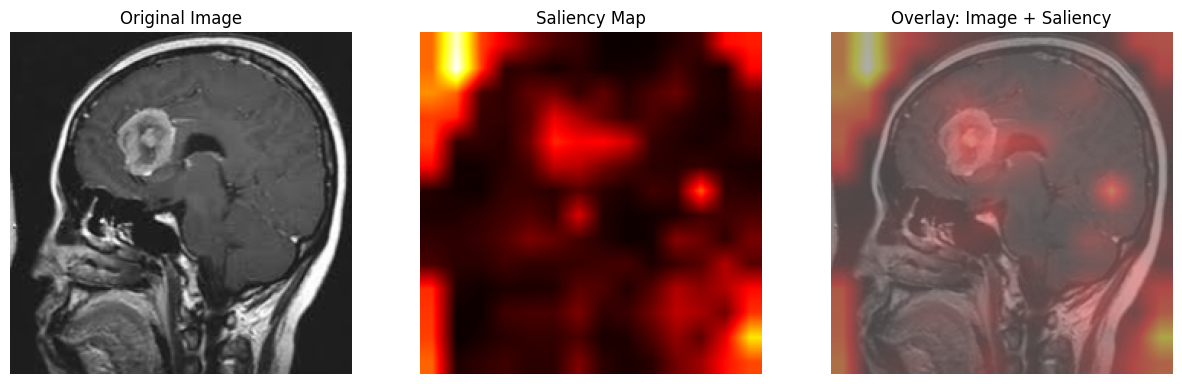

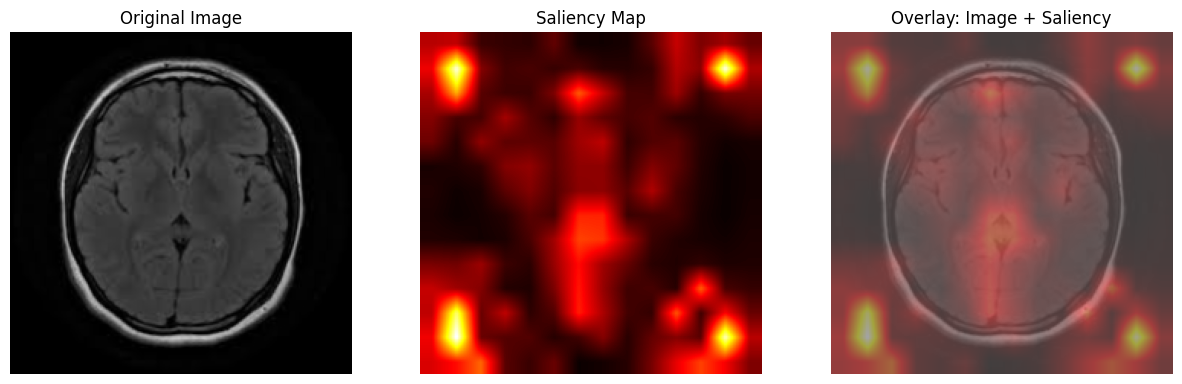

In [43]:
def visualize_vit_saliency_for_image(image_path, model, transform, title="ViT Saliency Map"):
    for handle in hook_handles:
        handle.remove()
    hook_handles.clear()
    attention_maps_list.clear()
    
    for layer in model.encoder.layers:
        if isinstance(layer.self_attention, AttentionCapture):
            handle = layer.self_attention.register_forward_hook(save_attention_map)
            hook_handles.append(handle)

# Load and transform image
    image = Image.open(image_path).convert("RGB")
    input_tensor = transform(image).unsqueeze(0).to(device)

    model.eval()
    with torch.no_grad():
        _ = model(input_tensor)

# Compute saliency map
    saliency_map = attention_rollout(attention_maps_list, discard_ratio=0.9)
    if saliency_map is not None:
        visualize_saliency(
            input_tensor[0].cpu(),
            saliency_map[0].cpu(),
            title=title
            )
    else:
        print("No saliency map was generated.")


visualize_vit_saliency_for_image(tumor_image_path, vit_model, test_tranform_no_aug, title="Tumor (Main Data) - ViT")
visualize_vit_saliency_for_image(no_tumor_image_path, vit_model, test_tranform_no_aug, title="No Tumor (External Data) - ViT")

In [44]:
def evaluate_with_outputs(vit_model_extension, loader):
    vit_model_extension.eval()
    all_preds = []
    all_labels = []
    with torch.no_grad():
        for X_batch, y_batch in loader:
            X_batch, y_batch = X_batch.to(device), y_batch.to(device)
            outputs = vit_model_extension(X_batch)
            preds = outputs.argmax(dim=1)
            all_preds.extend(preds.cpu().numpy())
            all_labels.extend(y_batch.cpu().numpy())
    return all_preds, all_labels

In [45]:
# evaluate both conditions
preds_no_aug_vit, labels_no_aug_vit = evaluate_with_outputs(vit_model, test_loader_no_aug)


In [46]:
# classification reports
print("classification report without argumentation:")
print(classification_report(labels_no_aug_vit, preds_no_aug_vit, target_names=['Non-Tumor', 'Tumor']))



classification report without argumentation:
              precision    recall  f1-score   support

   Non-Tumor       0.96      0.88      0.92        60
       Tumor       0.98      0.99      0.99       372

    accuracy                           0.98       432
   macro avg       0.97      0.94      0.95       432
weighted avg       0.98      0.98      0.98       432



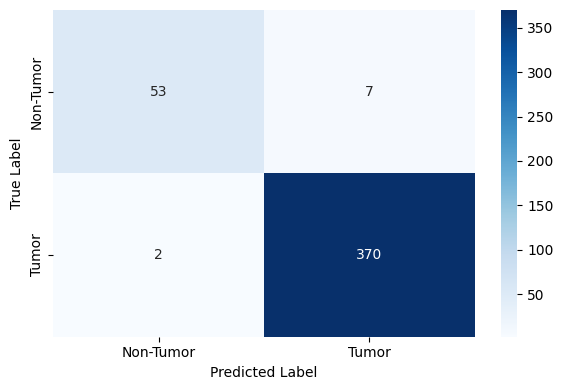

In [47]:
# confusion matrix
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

#without augmentation
cm_no_aug_vit = confusion_matrix(labels_no_aug_vit, preds_no_aug_vit)
plt.figure(figsize=(6,4))
sns.heatmap(cm_no_aug_vit, annot=True, fmt='d', cmap='Blues',
            xticklabels=['Non-Tumor', 'Tumor'],
            yticklabels=['Non-Tumor','Tumor'])
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('')
plt.tight_layout()
plt.show()




In [48]:
# evaluate unseen data with simclr
import os
import json
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
from torchvision import models, transforms
from PIL import Image
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt

In [49]:
def set_seed(seed=42):
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False
set_seed(42)

In [50]:
from glob import glob
class TumorDataset(Dataset):
    def __init__(self, data_path, transform=None):
        
        self.samples = []
        self.label_map = {
            'no_tumor': 0,
            'tumor': 1
            }
        for label_name, label_value in self.label_map.items():
            folder_path = os.path.join(data_path, label_name)
            image_paths = glob(os.path.join(folder_path, '*'))

            for image_path in image_paths:
                self.samples.append((
                    image_path, label_value
                    ))   
            self.transform = transform

    def __len__(self):
        return len(self.samples)

    def __getitem__(self, idx):
        image_path, label = self.samples[idx]
        image = Image.open(image_path).convert('RGB')
        if self.transform:
            image = self.transform(image)
        return image, label

In [51]:
# without augmentation: just re-size and normalize
test_tranform_no_aug = transforms.Compose([
        transforms.Resize(224),
        transforms.CenterCrop(224),
        transforms.ToTensor(),
        transforms.Normalize([0.5],[0.5])
    ])



In [52]:
test_no_aug = TumorDataset(
    data_path = test_path,
    transform=test_tranform_no_aug
)

test_loader_no_aug = DataLoader(test_no_aug, batch_size = 32)


In [53]:
# load the saved best saved model
device = torch.device('cuda' if torch.cuda.is_available() else "cpu")

In [54]:
encoder_dir = os.path.join(PROJECT_ROOT, 'SimCLR')
encoder_filename = 'best_simclr_encoder_only.pth'
encoder_path = os.path.join(encoder_dir, encoder_filename)
encoder=models.resnet18(weights=None)
encoder.fc = nn.Identity()
encoder.load_state_dict(torch.load(encoder_path))
encoder = encoder.to(device)
encoder.eval()

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

In [55]:
class LinearClassifier(nn.Module):
    def __init__(self, encoder, feature_dim, num_classes):
        super(LinearClassifier, self).__init__()
        self.encoder = encoder
        for param in self.encoder.parameters():
            param.requires_grad = False
        self.classifier = nn.Linear(feature_dim, num_classes)

    def forward(self, x):
        h = self.encoder(x)
        return self.classifier(h)
        

In [56]:
model_dir_simclr= os.path.join(PROJECT_ROOT, 'SimCLR')
model_filename_simclr = 'best_simclr_overall.pth'
model_path_simclr = os.path.join(model_dir_simclr, model_filename_simclr)
simclr_model = LinearClassifier(encoder = encoder, feature_dim=512, num_classes=2).to(device)
simclr_model .load_state_dict(torch.load(model_path_simclr))
simclr_model  = simclr_model .to(device)
simclr_model .eval()

LinearClassifier(
  (encoder): ResNet(
    (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu): ReLU(inplace=True)
    (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (layer1): Sequential(
      (0): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu): ReLU(inplace=True)
        (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      )
      (1): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, 

label value:  1
True label:  Tumor


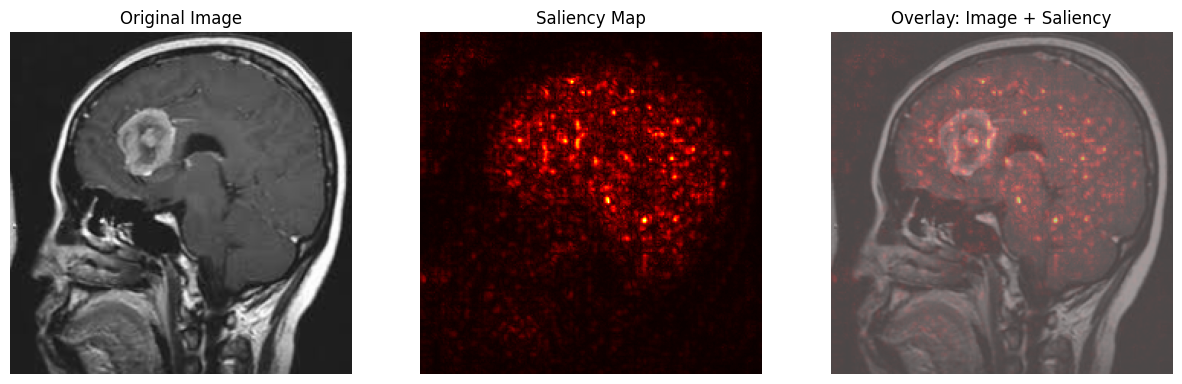

label value:  0
True label:  No Tumor


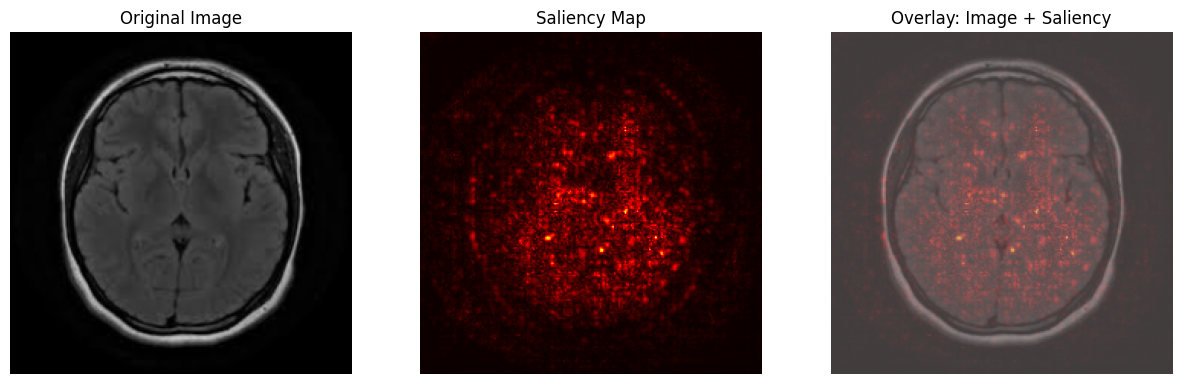

In [57]:
import matplotlib.pyplot as plt
import numpy as np

def generate_saliency_map(model, image_tensor, label, device):
    image_tensor = image_tensor.unsqueeze(0).to(device) # shape:(3, H, W) --> (1,3,H,W)
    image_tensor.requires_grad_() # compute gradient with respect to the input image

    output = model(image_tensor)  
    output[0, label].backward() # compute gradients of the output(specific class logit) with respect to the input image
                                # backpropagates from the score for the true class. 
    saliency = image_tensor.grad.data.abs().squeeze().cpu() 
    # this measure the rate of change of output score with respect to a tiny change in that pixel.
    # squeeze() removes batch dimension. (3, 224, 224)



    saliency, _ = torch.max(saliency, dim=0) 
    # reduce channels (R,G,B) to a 2D saliency map with the max gradient across channels at each pixel.
    # before max(), the shape is (3,224,224), after max(), the shape is (224,224)

    return saliency 

# tumor image
sample_img, sample_label = test_no_aug[tumor_idx] 
# after calling test_no_aug, the sample_img tensor shape is (3, 224, 224), its correpsonding output value e.g tensor([0.76, 0.72. 0.87])

saliency_map = generate_saliency_map(simclr_model, sample_img, sample_label, device)
print("label value: ", sample_label)
print("True label: ", "Tumor" if sample_label == 1 else "No Tumor")

# Denormalize for display
mean = np.array([0.5, 0.5, 0.5])
std = np.array([0.5, 0.5, 0.5])
sample_img_disp = sample_img.permute(1,2,0).cpu().numpy() 
sample_img_disp = std * sample_img_disp + mean
sample_img_disp = np.clip(sample_img_disp, 0, 1)

plt.figure(figsize=(15,5))

# Original Image
plt.subplot(1, 3, 1)
plt.imshow(sample_img_disp) #sample_img (H,W,3)
plt.title('Original Image')
plt.axis('off')

# Saliency Map
plt.subplot(1, 3, 2)
plt.imshow(saliency_map, cmap='hot') 
# saliency_map shows the saliency value- bright red~ high sensitivity (pixel changes influence prediction strongly)
# cmap = 'hot': is a colormap that maps scalar values to RGB colors for visualization. 

plt.title('Saliency Map')
plt.axis('off')

# Overlay
plt.subplot(1, 3, 3)
plt.imshow(sample_img_disp, alpha=0.6)
plt.imshow(saliency_map, cmap='hot', alpha=0.4)
plt.title('Overlay: Image + Saliency')
plt.axis('off')

plt.show()

# no-tumor image
sample_img, sample_label = test_no_aug[no_tumor_idx] 
# after calling test_no_aug, the sample_img tensor shape is (3, 224, 224), its correpsonding output value e.g tensor([0.76, 0.72. 0.87])

saliency_map = generate_saliency_map(simclr_model, sample_img, sample_label, device)
print("label value: ", sample_label)
print("True label: ", "Tumor" if sample_label == 1 else "No Tumor")

# Denormalize for display
mean = np.array([0.5, 0.5, 0.5])
std = np.array([0.5, 0.5, 0.5])
sample_img_disp = sample_img.permute(1,2,0).cpu().numpy() 
sample_img_disp = std * sample_img_disp + mean
sample_img_disp = np.clip(sample_img_disp, 0, 1)

plt.figure(figsize=(15,5))

# Original Image
plt.subplot(1, 3, 1)
plt.imshow(sample_img_disp) #sample_img (H,W,3)
plt.title('Original Image')
plt.axis('off')

# Saliency Map
plt.subplot(1, 3, 2)
plt.imshow(saliency_map, cmap='hot') 
# saliency_map shows the saliency value- bright red~ high sensitivity (pixel changes influence prediction strongly)
# cmap = 'hot': is a colormap that maps scalar values to RGB colors for visualization. 

plt.title('Saliency Map')
plt.axis('off')

# Overlay
plt.subplot(1, 3, 3)
plt.imshow(sample_img_disp, alpha=0.6)
plt.imshow(saliency_map, cmap='hot', alpha=0.4)
plt.title('Overlay: Image + Saliency')
plt.axis('off')

plt.show()



In [58]:
def evaluate_with_outputs(simclr_model, loader):
    simclr_model.eval()
    all_preds = []
    all_labels = []
    with torch.no_grad():
        for X_batch, y_batch in loader:
            X_batch, y_batch = X_batch.to(device), y_batch.to(device)
            outputs = simclr_model(X_batch)
            preds = outputs.argmax(dim=1)
            all_preds.extend(preds.cpu().numpy())
            all_labels.extend(y_batch.cpu().numpy())
    return all_preds, all_labels

In [59]:
# evaluate both conditions
preds_no_aug_simclr, labels_no_aug_simclr = evaluate_with_outputs(simclr_model, test_loader_no_aug)


In [60]:
# classification reports
print("classification report without argumentation:")
print(classification_report(labels_no_aug_simclr, preds_no_aug_simclr, target_names=['Non-Tumor', 'Tumor']))


classification report without argumentation:
              precision    recall  f1-score   support

   Non-Tumor       0.89      0.83      0.86        60
       Tumor       0.97      0.98      0.98       372

    accuracy                           0.96       432
   macro avg       0.93      0.91      0.92       432
weighted avg       0.96      0.96      0.96       432



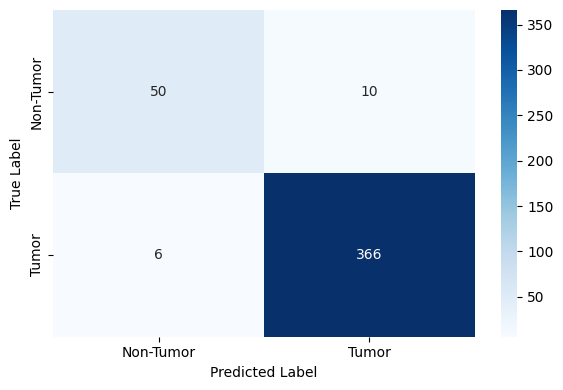

In [61]:
# confusion matrix
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

#without augmentation
cm_no_aug_simclr = confusion_matrix(labels_no_aug_simclr, preds_no_aug_simclr)
plt.figure(figsize=(6,4))
sns.heatmap(cm_no_aug_simclr, annot=True, fmt='d', cmap='Blues',
            xticklabels=['Non-Tumor', 'Tumor'],
            yticklabels=['Non-Tumor','Tumor'])
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('')
plt.tight_layout()
plt.show()
